In [1]:
# importing libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D, MaxPool1D, LeakyReLU, ELU, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tensorboardcolab import *
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pickle

Using TensorFlow backend.


In [2]:
# https://medium.com/@rushic24/mounting-google-drive-in-google-colab-5ecd1d3b735a
# https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92#targetText=To%20start%2C%20log%20into%20your,Colab%20has%20it%20installed%20already).

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# reading datasets

project_data = pd.read_csv("/content/drive/My Drive/Data/preprocessed_data.csv")
#pd.read_csv("preprocessed_data.csv")
project_data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 9)
--------------------------------------------------
The attributes of data : ['school_state' 'teacher_prefix' 'project_grade_category'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'clean_categories' 'clean_subcategories' 'essay' 'price']


In [5]:
approved_project = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [0]:
# Data splitting

from sklearn.model_selection import train_test_split

# Splitting in train and test
X_train, X_test, y_train, y_test = train_test_split(project_data, approved_project, test_size=0.33, stratify=approved_project)



In [7]:
#clearing the graph of tensorflow
tf.keras.backend.clear_session()

input_seq_total_text_data = Input(shape=(300,),name="input_seq_total_text_data")

In [8]:
# https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# prepare tokenizer
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(X_train["essay"])
vocab_size = len(text_tokenizer.word_index) + 1
vocab_size

48319

In [0]:
# integer encode the data

encoded_essay_train = text_tokenizer.texts_to_sequences(X_train["essay"])
encoded_essay_test = text_tokenizer.texts_to_sequences(X_test["essay"])


In [10]:
# Padding data

padded_text_train = pad_sequences(encoded_essay_train, maxlen=300, padding='post', truncating='post')
padded_text_test = pad_sequences(encoded_essay_test, maxlen=300, padding='post', truncating='post')

print(padded_text_train.shape)
print(padded_text_test.shape)




(73196, 300)
(36052, 300)


In [0]:
f = open("/content/drive/My Drive/Data/glove_vectors", "rb")
glove_words = pickle.load(f)

In [12]:
# create a weight matrix for words in training docs

embedding_matrix = np.zeros((vocab_size, 300))
for word, i in text_tokenizer.word_index.items():
    
    embedding_vector = glove_words.get(word)
    if embedding_vector is not None:
        
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

(48319, 300)


In [13]:
Emb_Txt_Data = Embedding(vocab_size, 300, weights = [embedding_matrix], input_length = 300, trainable=False)

In [14]:
Emb_Text_Data = (Emb_Txt_Data)(input_seq_total_text_data)

In [15]:
Emb_Text_Data

<tf.Tensor 'embedding_1/embedding_lookup/Identity:0' shape=(?, 300, 300) dtype=float32>

In [16]:
lstm = LSTM(64, recurrent_dropout=0.5, kernel_regularizer = regularizers.l2(0.001), return_sequences = True)(Emb_Text_Data)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
lstm

<tf.Tensor 'lstm_1/transpose_1:0' shape=(?, ?, 64) dtype=float32>

In [0]:
flatten = Flatten()(lstm)

In [19]:
flatten

<tf.Tensor 'flatten_1/Reshape:0' shape=(?, ?) dtype=float32>

In [0]:
# processing for school state

input_school_state = Input(shape=(50,),name="input_school_state")

In [21]:
unique_school_state  = X_train["school_state"].nunique()
print(unique_school_state)

Emb_State_Data = Embedding(unique_school_state, 300, input_length = 50)(input_school_state)

51


In [0]:
flatten_1 = Flatten()(Emb_State_Data)

In [0]:
encoded_school_state_train = [one_hot(d, unique_school_state) for d in X_train['school_state']]
encoded_school_state_test = [one_hot(d, unique_school_state) for d in X_test['school_state']]


In [24]:
padded_school_state_train = pad_sequences(encoded_school_state_train, maxlen=50, padding='post')
padded_school_state_test = pad_sequences(encoded_school_state_test, maxlen=50, padding='post')

print(padded_school_state_train.shape)
print(padded_school_state_test.shape)

(73196, 50)
(36052, 50)


In [25]:
# processing for project grade category

input_project_grade_category = Input(shape=(50,),name="input_project_grade_category")

unique_project_grade  = X_train["project_grade_category"].nunique()
print(unique_project_grade)

Emb_PGC_Data = Embedding(unique_project_grade, 300, input_length = 50)(input_project_grade_category)
flatten_2 = Flatten()(Emb_PGC_Data)



4


In [26]:
encoded_project_grade_train = [one_hot(d, unique_project_grade) for d in X_train['project_grade_category']]
encoded_project_grade_test = [one_hot(d, unique_project_grade) for d in X_test['project_grade_category']]

padded_project_grade_train = pad_sequences(encoded_project_grade_train, maxlen=50, padding='post')
padded_project_grade_test = pad_sequences(encoded_project_grade_test, maxlen=50, padding='post')

print(padded_project_grade_train.shape)
print(padded_project_grade_test.shape)

(73196, 50)
(36052, 50)


In [27]:
# processing for clean categories

input_clean_categories = Input(shape=(50,),name="input_clean_categories")

unique_clean_categories  = X_train["clean_categories"].nunique()
print(unique_clean_categories)

Emb_clean_categories_Data = Embedding(unique_clean_categories, 300, input_length = 50)(input_clean_categories)
flatten_3 = Flatten()(Emb_clean_categories_Data)



51


In [28]:
encoded_clean_categories_train = [one_hot(d, unique_clean_categories) for d in X_train['clean_categories']]
encoded_clean_categories_test = [one_hot(d, unique_clean_categories) for d in X_test['clean_categories']]

padded_clean_categories_train = pad_sequences(encoded_clean_categories_train, maxlen=50, padding='post')
padded_clean_categories_test = pad_sequences(encoded_clean_categories_test, maxlen=50, padding='post')


print(padded_clean_categories_train.shape)
print(padded_clean_categories_test.shape)

(73196, 50)
(36052, 50)


In [29]:
# processing for clean subcategories

input_clean_subcategories = Input(shape=(50,),name="input_clean_subcategories")

unique_clean_subcategories  = X_train["clean_subcategories"].nunique()
print(unique_clean_subcategories)

Emb_clean_subcategories_Data = Embedding(unique_clean_subcategories, 300, input_length = 50)(input_clean_subcategories)
flatten_4 = Flatten()(Emb_clean_subcategories_Data)



394


In [30]:
encoded_clean_subcategories_train = [one_hot(d, unique_clean_subcategories) for d in X_train['clean_subcategories']]
encoded_clean_subcategories_test = [one_hot(d, unique_clean_subcategories) for d in X_test['clean_subcategories']]

padded_clean_subcategories_train = pad_sequences(encoded_clean_subcategories_train, maxlen=50, padding='post')
padded_clean_subcategories_test = pad_sequences(encoded_clean_subcategories_test, maxlen=50, padding='post')

print(padded_clean_subcategories_train.shape)
print(padded_clean_subcategories_test.shape)

(73196, 50)
(36052, 50)


In [31]:
# processing for teacher prefix

input_teacher_prefix = Input(shape=(50,),name="input_teacher_prefix")

unique_teacher_prefix  = X_train["teacher_prefix"].nunique()
print(unique_teacher_prefix)

Emb_teacher_prefix_Data = Embedding(unique_teacher_prefix, 300, input_length = 50)(input_teacher_prefix)
flatten_5 = Flatten()(Emb_teacher_prefix_Data)



5


In [32]:
encoded_teacher_prefix_train = [one_hot(d, unique_teacher_prefix) for d in X_train['teacher_prefix']]
encoded_teacher_prefix_test = [one_hot(d, unique_teacher_prefix) for d in X_test['teacher_prefix']]

padded_teacher_prefix_train = pad_sequences(encoded_teacher_prefix_train, maxlen=50, padding='post')
padded_teacher_prefix_test = pad_sequences(encoded_teacher_prefix_test, maxlen=50, padding='post')

print(padded_teacher_prefix_train.shape)
print(padded_teacher_prefix_test.shape)

(73196, 50)
(36052, 50)


In [33]:
# Processing numerical features

input_numerical_data = Input(shape=(2,),name="input_numerical_data")

Dense_for_rem_input = Dense(units=32,activation='relu',kernel_initializer='he_normal',name="Dense_for_rem_input")(input_numerical_data)

In [0]:
teacher_number_of_previously_posted_projects_train = X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
price_train = X_train['price'].values.reshape(-1, 1)

teacher_number_of_previously_posted_projects_test = X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)
price_test = X_test['price'].values.reshape(-1, 1)

concat_numerical_train = np.concatenate((teacher_number_of_previously_posted_projects_train,price_train),axis=1)
concat_numerical_test = np.concatenate((teacher_number_of_previously_posted_projects_test,price_test),axis=1)

In [0]:
concatenate = concatenate(inputs=[flatten, flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, input_numerical_data],name="concatenate")

In [36]:
Dense_layer1_after_concat = Dense(128,activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(concatenate)

dropout = Dropout(0.5)(Dense_layer1_after_concat)

Dense_layer2_after_concat = Dense(64,activation="relu", kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(dropout)

dropuout_1 = Dropout(0.5)(Dense_layer2_after_concat)

Dense_layer3_after_concat = Dense(32,activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(dropuout_1)

Dense_layer4_after_concat = Dense(16,activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001))(Dense_layer3_after_concat)

output_layer_to_classify_with_softmax = Dense(2,activation='softmax',kernel_initializer="he_normal",name="output")(Dense_layer4_after_concat)

model_1 = Model(inputs=[input_seq_total_text_data,input_school_state,input_project_grade_category,input_clean_categories,input_clean_subcategories,input_teacher_prefix,input_numerical_data],outputs=[output_layer_to_classify_with_softmax])

model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data (Inpu (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     14495700    input_seq_total_text_data[0][0]  
__________________________________________________________________________________________________
input_school_state (InputLayer) (None, 50)           0                                            
__________________________________________________________________________________________________
input_project_grade_category (I (None, 50)           0                                            
____________________________________________________________________________________________

In [37]:
# https://github.com/taomanwai/tensorboardcolab/blob/master/README.md

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://6291a79d.ngrok.io


In [0]:
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# https://medium.com/singlestone/keras-callbacks-monitor-and-improve-your-deep-learning-205a8a27e91c
# https://www.tensorflow.org/tensorboard/get_started
# https://keras.rstudio.com/reference/callback_tensorboard.html
# https://colab.research.google.com/drive/1afN2SALDooZIHbBGmWZMT6cZ8ccVElWk#scrollTo=4pxUfiLhbS4Y&forceEdit=true&sandboxMode=true

#tensorboard_model_1 = TensorBoard(log_dir='./log', histogram_freq=1, write_graph=True, write_grads=True, batch_size=512, write_images=True)

#callbacks_1 = [tensorboard_model_1]

In [0]:
model_1_train_data = [padded_text_train,padded_school_state_train,padded_project_grade_train,padded_clean_categories_train,padded_clean_subcategories_train,padded_teacher_prefix_train,concat_numerical_train]

model_1_test_data = [padded_text_test,padded_school_state_test,padded_project_grade_test,padded_clean_categories_test,padded_clean_subcategories_test,padded_teacher_prefix_test,concat_numerical_test]


In [0]:
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, 2) 
Y_test = np_utils.to_categorical(y_test, 2)

In [0]:
# https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras

def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [42]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])



Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [43]:
history = model_1.fit(model_1_train_data, Y_train, batch_size=512, epochs=20, verbose=1, validation_data=(model_1_test_data, Y_test), callbacks=[TensorBoardColabCallback(tbc)])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 73196 samples, validate on 36052 samples


Epoch 1/20
73196/73196 [==============================] - 115s 2ms/step - loss: 0.7977 - auroc: 0.6039 - val_loss: 0.6384 - val_auroc: 0.7193

Epoch 2/20
73196/73196 [==============================] - 113s 2ms/step - loss: 0.5497 - auroc: 0.6927 - val_loss: 0.5446 - val_auroc: 0.7346
Epoch 3/20
73196/73196 [==============================] - 113s 2ms/step - loss: 0.5031 - auroc: 0.7088 - val_loss: 0.5081 - val_auroc: 0.7440
Epoch 4/20
73196/73196 [==============================] - 115s 2ms/step - loss: 0.4750 - auroc: 0.7186 - val_loss: 0.4785 - val_auroc: 0.7344
Epoch 5/20
73196/73196 [==============================] - 116s 2ms/step - loss: 0.4534 - auroc: 0.7271 - val_loss: 0.4611 - val_auroc: 0.7533
Epoch 6/20
73196/73196 [==============================] - 112s 2ms/step - loss: 0.4377 - auroc: 0.7346 - val_loss: 0.4467 - val_auroc: 0.7550

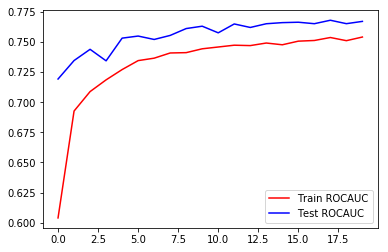

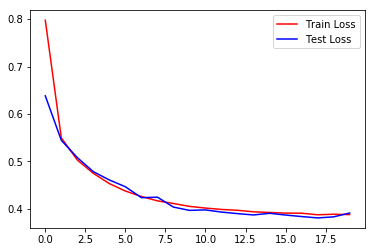

In [44]:
plt.plot(history.history['auroc'], 'r')
plt.plot(history.history['val_auroc'], 'b')
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})
plt.show()


plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.legend({'Train Loss': 'r', 'Test Loss':'b'})
plt.show()

Model ROCAUC Value is 0.7672.